# Finite temperature antiferromagnetism in two dimensional systems

## Mermin-Wagner theorem

The Mermin-Wagner theorem [[Mermin and Wagner, Phys. Rev. Lett. 17, 1133 (1966)]](https://doi.org/10.1103/PhysRevLett.17.1133) states that a continuous-symmetry cannot be broken at finite temperature in two dimensions. So, finite temperature antiferromagnetism is impossible in two dimensions, contrary to the prediction of RPA. 

Here is a heuristic proof. Assume that the system has long range order and that the spins are collinear in the $z$-direction. Then the free energy density contains a term proportional to $(\nabla S^z)^2/2$, where $S^z$ is the spin density operator in the $z$-direction. In Fourier space, this becomes $-q^2|S^z(\mathbf{q})|^2/2$. In the long wavelength limit, where fluctuations are slow, we can use the classical equipartition theorem which gives 
$$
|S^z(\mathbf{q})|^2=\frac{k_BT}{q^2} \, .
$$
However, the denominator gives rise to a so called *infrared divergence* which cause the local moment to diverge 
$$
\left<(S^z)^2\right>\sim \int d^2q |S^z(\mathbf{q})|^2\sim \int d^2q\frac{k_BT}{q^2}=\infty \, .
$$
We come to an absurdity, which proves that our initial hypothesis of the existence of long range order is wrong. Hence, there is no long-range order. 

## TPSC and the Mermin-Wagner theorem

To see that TPSC satisfies the Mermin-Wagner theorem, we first note that the spin susceptibility has the following spectral representation

$$\chi_{sp}(\mathbf{q},i\omega_n)=\int\frac{d\omega}{\pi}\frac{\chi_{sp}''(\mathbf{q},\omega)}{\omega-i\omega_n}=\int\frac{d\omega}{\pi}\frac{\chi_{sp}''(\mathbf{q},\omega)\omega}{\omega^2+(\omega_n)^2}.$$

The last equality follows from the fact $\chi_{sp}''(\mathbf{q},\omega)$ is odd in frequency. This last result shows that the finite Matsubara frequencies should be regular and that the largest contribution is at the zeroth-Matsubara frequency. This allows us to give a rough idea of why the theorem is satisfied by focusing on the zero Matsubara frequency contribution. 

Let us write the self-consistency condition for $U_{sp}$ as follows

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q}} \frac{\chi_0(\mathbf{q},0)}{1-\frac{U_{sp}}{2}\chi_0(\mathbf{q},0)}=n-2\left< n_\uparrow n_\downarrow\right>-C(T)
\end{equation}

where $C(T)$ contains the non-singular contribution of the finite Matsubara frequencies. 

Calling the right-hand side $C'(T)$, expanding the denominator around the maximum at $\mathbf{Q}=(\pi,\pi)$ and shifting the origin of the wave vector integration to $\mathbf{Q}=(\pi,\pi)$, the self-consistency condition can be written as  

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q}} \frac{A}{\xi^{-2}+q^2}=C'(T)
\end{equation}
where $A$ is a constant and $\xi$ the correlation length contains the value of $U_{sp}$. Since the right-hand side is finite, $\xi$ adjusts itself not to become infinite, otherwise the left-hand side diverges. The divergence of the susceptibility can occur only at $T=0$ where we cannot treat the non-zero Matsubara frequencies separately. 




## Code from previous notebooks

To study the temperature dependence we will reuse the code from the previous TPSC notebook. Please look through the functions and make sure that they are familiar.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
from triqs.plot.mpl_interface import plt, oplot

import numpy as np
from triqs.gf import *

## $\chi_0$ calculator for arbitrary $\beta$

Since we have to recompute the bare bubble $\chi_0$ for every temperature we also need an implementation `get_chi0` of the bubble calculation, see below.

In [2]:
from triqs.lattice.tight_binding import TBLattice

t = 1.0 # nearest-neigbhour hopping amplitude

H_r = TBLattice( 
    units=[
        (1,0,0), # basis vector in the x-direction 
        (0,1,0), # basis vector in the y-direction
    ],
    hoppings={
        (+1,0) : [[-t]], # hopping in the +x direction
        (-1,0) : [[-t]], # hopping in the -x direction
        (0,+1) : [[-t]], # hopping in the +y direction
        (0,-1) : [[-t]], # hopping in the -y direction
    })

kmesh = H_r.get_kmesh(n_k=16)
e_k = H_r.fourier(kmesh)

from triqs.gf import MeshImFreq
from triqs_tprf.lattice import lattice_dyson_g0_wk
from triqs_tprf.lattice_utils import imtime_bubble_chi0_wk

def get_chi0(beta, n_iw=128):
    wmesh = MeshImFreq(beta=beta, S='Fermion', n_iw=64)
    g0_wk = lattice_dyson_g0_wk(mu=0., e_k=e_k, mesh=wmesh)
    chi0_wk = 2 * imtime_bubble_chi0_wk(g0_wk, nw=32, verbose=False)
    return chi0_wk

Starting serial run at: 2023-08-29 11:09:45.617709


Here are the functions used for the TPSC self consistency.

In [3]:
from scipy.optimize import brentq

from triqs_tprf.lattice import solve_rpa_PH

def solve_rpa(chi0_wk, U):
    I = np.ones([1, 1, 1, 1], dtype=complex)
    chi_wk = solve_rpa_PH(chi0_wk, U/2 * I)
    return chi_wk

def trace_chi(chi_wk):
    """Compute the sum, \sum_k \sum_\nu \chi(k,\nu)""" 
    wmesh, kmesh = chi_wk.mesh.components
    chi_w = Gf(mesh=wmesh, target_shape=[])
    chi_w.data[:] = np.sum(np.squeeze(chi_wk.data), axis=1) / len(kmesh)
    return -chi_w.density().real

def Usp_root(Usp, chi0_wk, n, U):
    tr_chi_sp = trace_chi(solve_rpa(chi0_wk, U=Usp))
    diff = tr_chi_sp + 0.5 * Usp/U * n**2 - n
    return diff

def Uch_root(Uch, chi0_wk, n, U, docc):
    tr_chi = trace_chi(solve_rpa(chi0_wk, U=-Uch))
    diff = tr_chi - 2 * docc - n + n**2
    return diff

def solve_tpsc(chi0_wk, U, n):
    Uc = 2/np.squeeze(chi0_wk(0, [np.pi, np.pi, 0])).real
    Usp = brentq(Usp_root, 0, Uc, args=(chi0_wk, n, U), xtol=1e-2)
    docc = 0.25 * Usp / U * n**2
    Uch = brentq(Uch_root, 0, 100, args=(chi0_wk, n, U, docc), xtol=1e-2)
    return Usp, Uch, docc, Uc

## <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise

Solve the TPCS equations for a range of temperatures at $n=1$ (half-filling) and $U=4$ and examine the validity of the Mermin-Wagner theorem in the TPSC approximation. In particular study the spin structure factor $S(\mathbf{q})$ defined as 

$$
S(\mathbf{q})\equiv T\sum_n \chi_{sp}(\mathbf{q},i\omega_n)
$$

and reproduce the results of following figure from __[[Vilk and Tremblay, J. Phys. I France 7 (1997) 1309-1368]](https://jp1.journaldephysique.org/articles/jp1/abs/1997/11/jp1v7p1309/jp1v7p1309.html)__ __[[arXiv version]](https://arxiv.org/abs/cond-mat/9702188v3)__:
<img src="./imgs/Fig7.png" alt="Drawing" style="width: 250px;"/>


## RPA spin structure factor $S_{RPA}$ as a function of temperature $T$

For comparison we compute the RPA spin structure factor $S_{RPA}$ for a range of temperatures. Note that $T_c^{(RPA)} \approx 0.75$.

In [4]:
U = 4.0
n = 1.0

T_rpa_vec = np.concatenate((np.arange(4., 3., -1.), np.arange(3, 0.75, -0.2)))
S_rpa_vec = np.zeros_like(T_rpa_vec)

print(''.join('| %-11s' % s for s in ['T', 'beta', 'S_rpa']), '|')
print('-'*41)

for idx, T in enumerate(T_rpa_vec):

    beta = 1. / T
    chi0_wk = get_chi0(beta)
    chi_wk = solve_rpa(chi0_wk, U)
    
    S_rpa = -chi_wk(all, (np.pi, np.pi, 0))[0,0,0,0].density().real * beta
    S_rpa_vec[idx] = S_rpa
    
    print(''.join('| %4.4E ' % x for x in [T, beta, S_rpa_vec[idx]]), '|')    

| T          | beta       | S_rpa       |
-----------------------------------------
| 4.0000E+00 | 2.5000E-01 | 1.7196E-01  |
| 3.0000E+00 | 3.3333E-01 | 2.5925E-01  |
| 2.8000E+00 | 3.5714E-01 | 2.8783E-01  |
| 2.6000E+00 | 3.8462E-01 | 3.2302E-01  |
| 2.4000E+00 | 4.1667E-01 | 3.6725E-01  |
| 2.2000E+00 | 4.5455E-01 | 4.2425E-01  |
| 2.0000E+00 | 5.0000E-01 | 5.0006E-01  |
| 1.8000E+00 | 5.5556E-01 | 6.0503E-01  |
| 1.6000E+00 | 6.2500E-01 | 7.5858E-01  |
| 1.4000E+00 | 7.1429E-01 | 1.0020E+00  |
| 1.2000E+00 | 8.3333E-01 | 1.4436E+00  |
| 1.0000E+00 | 1.0000E+00 | 2.5028E+00  |
| 8.0000E-01 | 1.2500E+00 | 9.9329E+00  |


## TPSC spin structure factor $S_{TPSC}$ as a function of temperature

Using the ansatz $U_{sp}\left<n_\uparrow\right> \left<n_\downarrow\right>=U\left<n_\uparrow n_\downarrow\right>$, the spin susceptibility obeys

\begin{equation}
\frac{T}{N}\sum_{\mathbf{q},i\omega_n} \frac{\chi_0(\mathbf{q},i\omega_n)}{1-\frac{U\left<n_\uparrow n_\downarrow\right>}{2\left<n_\uparrow\right> \left<n_\downarrow\right>}\chi_0(\mathbf{q},i\omega_n)}=n-2\left< n_\uparrow n_\downarrow\right>
\end{equation}

When the susceptibility increases, $\left<n_\uparrow n_\downarrow\right>$ on the right-hand side decreases, but then the denominator of the spin susceptibility will lead to a decrease in susceptibility.

More rigorously, we can see that dimension is important here. Let us repeat the argument at the beginning of the notebook. The right-hand side of the equation cannot diverge. Also, on the left-hand side, note that the most divergent contribution is the zero Matsubara frequency, as one can see from the spectral representation and $\chi''(\mathbf{q},\omega)=-\chi''(\mathbf{q},-\omega)$

\begin{equation}
\chi(\mathbf{q},i\omega_n)=\int \frac{d\omega}{\pi}\frac{\chi''(\mathbf{q},\omega)}{\omega-i\omega_n}=\int \frac{d\omega}{\pi}\frac{\omega\chi''(\mathbf{q},\omega)}{\omega^2+\omega_n^2}.
\end{equation}

Using these results, the non-singular finite Matsubara frequency terms can be put on the right-hand side of the sum rule and all that is left is 

\begin{equation}
T\int d^2q \frac{a}{\xi^{2}+q^2}\sim C'(T)
\end{equation}

where we have expanded the susceptibility around $(\pi,\pi)$, gone from sum to integral and shifted the origin of integration so that now $\mathbf{q}$ is the deviation from $(\pi,\pi)$. On dimensional grounds, the left-hand side is logarithmic in two dimensions so that the correlation length scales like $\exp(C'(T)/T)$.


## <i class="fa fa-gear fa-x" style="color: #186391"></i> Exercise: Spin structure factor

Compute the TPSC spin structure factor for a range of temperatures $T \in [0.25, 4]$ and plot $S_{TPSC}$ and $S_{RPA}$ and determine whether the Mermin-Wagner theorem holds.

In [5]:
# Write your code here

T_tpsc_vec = np.array([ 4., 3., 
                       2.5, 2.0, 1.5, 1.2, 1.0, 
                       0.8, 0.6, 0.4, 0.35, 0.3, 0.25, 
                       ])

S_tpsc_vec = np.zeros_like(T_tpsc_vec)
U_sp_vec = np.zeros_like(T_tpsc_vec)
U_ch_vec = np.zeros_like(T_tpsc_vec)
docc_vec = np.zeros_like(T_tpsc_vec)

print(''.join('| %-11s' % s for s in ['T', 'beta', 'Usp', 'Uch', 'docc', 'S_tpsc']), '|')
print('-'*80)

for idx, T in enumerate(T_tpsc_vec):

    beta = 1. / T    
    chi0_wk = get_chi0(beta) 
    
    Usp, Uch, docc, UcRPA = solve_tpsc(chi0_wk, U, n)
    
    chi_sp_wk = solve_rpa(chi0_wk, Usp)
    S_tpsc = -chi_sp_wk(all, (np.pi, np.pi, 0))[0,0,0,0].density().real * beta

    S_tpsc_vec[idx], U_sp_vec[idx], U_ch_vec[idx], docc_vec[idx] = S_tpsc, Usp, Uch, docc 
    print(''.join('| %4.4E ' % x for x in [T, beta, Usp, Uch, docc, S_tpsc]), '|')    

| T          | beta       | Usp        | Uch        | docc       | S_tpsc      |
--------------------------------------------------------------------------------
| 4.0000E+00 | 2.5000E-01 | 3.1151E+00 | 4.9735E+00 | 1.9469E-01 | 1.6108E-01  |
| 3.0000E+00 | 3.3333E-01 | 2.9065E+00 | 5.3054E+00 | 1.8166E-01 | 2.3189E-01  |
| 2.5000E+00 | 4.0000E-01 | 2.7718E+00 | 5.5801E+00 | 1.7324E-01 | 2.9464E-01  |
| 2.0000E+00 | 5.0000E-01 | 2.6148E+00 | 6.0225E+00 | 1.6343E-01 | 3.9851E-01  |
| 1.5000E+00 | 6.6667E-01 | 2.4421E+00 | 6.8411E+00 | 1.5263E-01 | 5.9599E-01  |
| 1.2000E+00 | 8.3333E-01 | 2.3406E+00 | 7.7133E+00 | 1.4629E-01 | 8.2155E-01  |
| 1.0000E+00 | 1.0000E+00 | 2.2802E+00 | 8.5589E+00 | 1.4251E-01 | 1.0735E+00  |
| 8.0000E-01 | 1.2500E+00 | 2.2301E+00 | 9.6547E+00 | 1.3938E-01 | 1.5004E+00  |
| 6.0000E-01 | 1.6667E+00 | 2.1949E+00 | 1.0900E+01 | 1.3718E-01 | 2.3575E+00  |
| 4.0000E-01 | 2.5000E+00 | 2.1657E+00 | 1.2228E+01 | 1.3535E-01 | 4.8974E+00  |
| 3.5000E-01 | 2.8571E+00 | 

## <i class="fa fa-gear fa-x" style="color: #186391"></i> Excercise: Critical temperature and double occupancy

To see the divergencies it is useful to also study the inverse spin structure factor $S^{-1}$. Plot $S^{-1}$ and see at what temperatures the curves intercept $S^{-1}=0$ to determine the critical temperatures $T_c$ of RPA and TPSC.  Also plot the double occupancy and explain its behaviour as a function of temperature.

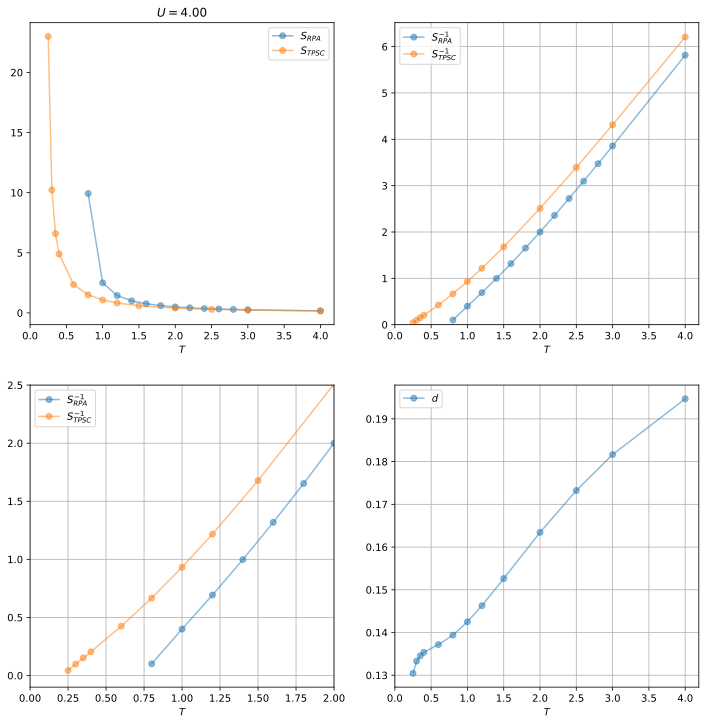

In [6]:
# Write your code here

plt.figure(figsize=(12, 12))
# This is to compare with the paper and RPA
plt.subplot(221)
plt.title(r'$U = %2.2f$' % U)
plt.plot(T_rpa_vec, S_rpa_vec, 'o-', label=r'$S_{RPA}$', alpha=0.5)
plt.plot(T_tpsc_vec, S_tpsc_vec, 'o-', label=r'$S_{TPSC}$', alpha=0.5)
plt.legend(loc='best')
plt.xlabel(r'$T$')
plt.xlim(left=0)

# By plotting the inverse of the structure factor, we look for a phase transition. 
plt.subplot(222)
plt.plot(T_rpa_vec, 1./S_rpa_vec, 'o-', alpha=0.5, label=r'$S_{RPA}^{-1}$')
plt.plot(T_tpsc_vec, 1./S_tpsc_vec, 'o-', alpha=0.5, label=r'$S_{TPSC}^{-1}$')
plt.legend(loc='best')
plt.xlabel(r'$T$'); plt.grid()
plt.xlim(left=0); plt.ylim(bottom=0)

# This is a blow up of the low temperature result. 
plt.subplot(223)
plt.plot(T_rpa_vec, 1./S_rpa_vec, 'o-', alpha=0.5, label=r'$S_{RPA}^{-1}$')
plt.plot(T_tpsc_vec, 1./S_tpsc_vec, 'o-', alpha=0.5, label=r'$S_{TPSC}^{-1}$')
plt.legend(loc='best'); plt.xlim([0, 2]); plt.ylim([-0.1, 2.5])
plt.xlabel(r'$T$'); plt.grid(); plt.xlim(left=0)

# This shows the behavior of U_sp as a function of temperature.
plt.subplot(224)
plt.plot(T_tpsc_vec, docc_vec, 'o-', alpha=0.5, label=r'$d$')
plt.legend(loc='best'); plt.xlabel(r'$T$'); plt.grid(); plt.xlim(left=0);

## Questions

- What is the $T \rightarrow \infty$ limit of the double occupancy?

**Answer**: Thermal excitations win over the interaction $U$ as temperature increases, whence the double occupancy increase as a function of temperature.

At the lowest temperatures, the sudden fall of double occupancy with decreasing $T$ corresponds to a suddent increase in local moment since $\langle S_z^2 \rangle = n - 2\langle n_\uparrow n_\downarrow \rangle$. The local moment should be large at low $T$ where the system has long range anitferromagnetic order. The sudden fall occurs at a temperature that is a remnant of the mean field transition temperature corresponding to $U_{sp}$. For details see __[[Kyung, Landry, Poulin, Tremblay, Phys. Rev. Lett. 90, 099702 (2003)]](https://doi.org/10.1103/PhysRevLett.90.099702)__.

In the high temperature limit all states of the single site have equal probability which for the double occupancy gives $\langle n_\uparrow n_\downarrow \rangle = 1/4$.


- There seems to be a finite transition temperature even for TPSC. If there is a numerical problem leading to that, can you identify it?

**Answer**: The zero-Matsubara frequency contribution to the local moment sum-rule is a logarithmically divergent integral when the correlation length is infinite. Since the right-hand side of the sum-rule is finite, the correlation length is forced to remain finite. If the momentum mesh is discrete and does not include $0$, the discrete numerical integral converges even for an infinite correlation length, so there is a finite transition temperature. See the remarks below for how to solve this problem. It amounts to basically doing a careful analysis of the asymptotic behavior, subtracting this asymptotic behavior in the numerical integral and adding the analytical expression for the asymptotic part.   

## Remarks
* To evaluate the integrals and sums entering the sum rules accurately, one must use several tricks that are described in appendix B of this __[[Daré, Vilk, Tremblay
Phys. Rev. B 53, 14236 (1996)]](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.53.14236)__.
* The asymptotic behavior of the self-consistency equation is done in a more rigorous way as an intermediate step in this [discussion of the critical behavior](http://iopscience.iop.org/article/10.1209/0295-5075/84/37013/meta).
* $U_{sp}$ vanishing as $T\rightarrow0$ is unphysical. It is a consequence of the fact that to avoid the phase transition, $U_{sp}$ must be smaller than the mean-field value $$ U_c^{(RPA)} = \frac{2}{\chi_0(\mathbf{Q}_{AF}, 0)} $$ which is zero at $T=0$ because the susceptibility diverges there for the perfectly nested Fermi surface.
* The results can be trusted at temperatures not too far below the rapid crossover in the renormalized classical regime where $\xi$ starts to grow exponentially. In particular, the sudden fall of $U_{sp}$ around $T=0.5$ is seen by other methods in this [comment](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.90.099702).
* The internal consistency condition $Tr[\Sigma G]=2U\left< n_\uparrow n_\downarrow \right>$ can be used to estimate the domain of validity of the approach.        